In [1]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap

In [2]:
# Parameters
num_parts = 6     # Number of parts
demand = {p: 4 for p in range(1, num_parts + 1)}  

parts_colors = {
    1: 'Red',
    2: 'Blue',
    3: 'Green',
    4: 'Yellow',
    5: 'Black',
    6: 'Red',
}

color_cost = {
    'Red': 10,
    'Blue': 10,
    'Green': 10,
    'Yellow': 10,
    'Black': 10
}

color_mapping = {
    'Red': 1,
    'Blue': 2,
    'Green': 3,
    'Yellow': 4,
    'Black': 5
}

unit_production_time = {
    1: 2,   
    2: 1,   
    3: 1,   
    4: 1,   
    5: 1,   
    6: 1,   
}

max_production_time = 30

In [3]:
model = gp.Model("PaintingProcessOptimization")

Restricted license - for non-production use only - expires 2025-11-24


In [4]:
# Define continuous variables for start and end times of production for each part
start_times = model.addVars(range(1, num_parts + 1), vtype=GRB.CONTINUOUS, name="start_times")
end_times = model.addVars(range(1, num_parts + 1), vtype=GRB.CONTINUOUS, name="end_times")

# Define binary variable to indicate order of parts
order = model.addVars(range(1, num_parts + 1), range(1, num_parts + 1), vtype=GRB.BINARY, name="order")
color_change = model.addVars(range(1, num_parts + 1), range(1, num_parts + 1), vtype=GRB.BINARY, name="color_change")

In [5]:
model.setObjective(
    quicksum(
        color_cost[parts_colors[p]] * color_change[p, q] for p in range(1, num_parts + 1) for q in range(1, num_parts + 1)
    ),
    GRB.MINIMIZE
)

In [6]:
# Ensure that if part p is ordered before part p', the order variable is set
for p in range(1, num_parts + 1):
    for p_prime in range(1, num_parts + 1):
        if p != p_prime:
            model.addConstr(order[p, p_prime] + order[p_prime, p] == 1, name=f"Order_Binary_{p}_{p_prime}")

for p in range(1, num_parts + 1):
    for p_prime in range(1, num_parts + 1):
        if p != p_prime:

            model.addConstr(
                color_change [p, p_prime] >= order[p, p_prime],
                name=f"Color_Change_{p}_{p_prime}"
            )

In [7]:
# Demand Fulfillment Constraints
for p in range(1, num_parts + 1):
    model.addConstr(
        (end_times[p] - start_times[p] ) * unit_production_time[p] >= demand[p],
        name=f"Demand_Fulfillment_{p}"
    )

# No Overlap Constraints
for p in range(1, num_parts + 1):  # Current part
    for p_prime in range(1, num_parts + 1):  # Next part
        if p != p_prime:  # Only check different parts
            
            # No overlap constraint: If part p is ordered before part p_prime
            model.addConstr(
                end_times[p] <= start_times[p_prime] + (1 - order[p, p_prime]) * 1e6,
                name=f"No_Overlap_{p}_{p_prime}"
            )

            # No overlap constraint: If part p_prime is ordered before part p
            model.addConstr(
                end_times[p_prime] <= start_times[p] + (1 - order[p_prime, p]) * 1e6,
                name=f"No_Overlap_Reverse_{p}_{p_prime}"
            )

In [8]:
model.optimize()

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.1.0 24B83)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 126 rows, 84 columns and 312 nonzeros
Model fingerprint: 0xc199ce48
Variable types: 12 continuous, 72 integer (72 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [1e+01, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Found heuristic solution: objective 150.0000000
Presolve removed 96 rows and 63 columns
Presolve time: 0.00s
Presolved: 30 rows, 21 columns, 90 nonzeros
Variable types: 6 continuous, 15 integer (15 binary)

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 150 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.500000000000e+02, best bound 1.500000000000e+02, gap 0.0000%


In [9]:
# Check if the model is infeasible
if model.status == GRB.INFEASIBLE:
    print("Model is infeasible. Computing IIS...")
    model.computeIIS()
    model.write("model.ilp")
    
    # Print the constraints that are part of the IIS
    print("\nThe following constraints are part of the IIS:")
    for c in model.getConstrs():
        if c.IISConstr:
            print(f"{c.constrName}")

Optimal solution found:


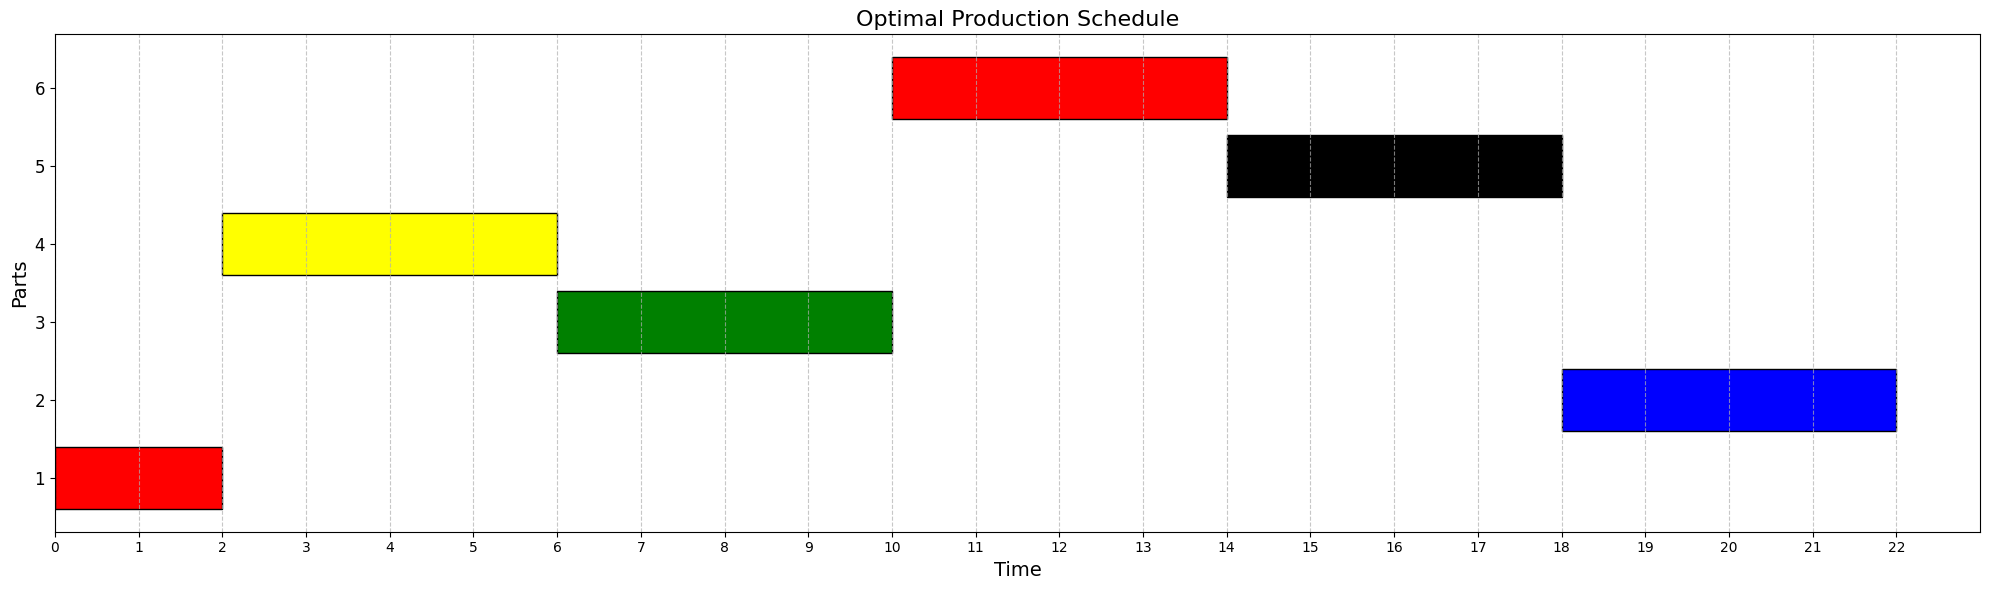

Minimized Total Cost (Objective Value): 150.0


In [10]:
if model.status == GRB.OPTIMAL:
    print("Optimal solution found:")
    
    # Extract start and end times for each part
    start_times_values = [start_times[p].X for p in range(1, num_parts + 1)]
    end_times_values = [end_times[p].X for p in range(1, num_parts + 1)]
    
    # Plotting the Gantt chart
    plt.figure(figsize=(20, 6))
    
    # Define color mapping for the parts
    color_map = {
        'Red': 'red',
        'Blue': 'blue',
        'Green': 'green',
        'Yellow': 'yellow',
        'Black': 'black'
    }

    for p in range(1, num_parts + 1):
        plt.barh(p, end_times_values[p-1] - start_times_values[p-1], left=start_times_values[p-1],
                 color=color_map[parts_colors[p]], edgecolor='black', label=parts_colors[p] if p == 1 else "")

    plt.title("Optimal Production Schedule", fontsize=16)
    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Parts", fontsize=14)
    plt.xticks(np.arange(0, max(end_times_values) + 1, 1))  # Set x-ticks according to time
    plt.yticks(range(1, num_parts + 1), fontsize=12)  # Set y-ticks for parts
    plt.grid(axis='x', linestyle='--', alpha=0.7)  # Optional grid for better visibility
    plt.xlim(0, max(end_times_values) + 1)  # Set x-axis limits to provide some padding
    plt.tight_layout()  # Adjust layout to prevent clipping of labels

    plt.show()
    
    # Display objective function result
    minimized_cost = model.ObjVal
    print(f"Minimized Total Cost (Objective Value): {minimized_cost}")

else:
    print("No optimal solution found.")

In [11]:
start_times

{1: <gurobi.Var start_times[1] (value 0.0)>,
 2: <gurobi.Var start_times[2] (value 18.0)>,
 3: <gurobi.Var start_times[3] (value 6.0)>,
 4: <gurobi.Var start_times[4] (value 2.0)>,
 5: <gurobi.Var start_times[5] (value 14.0)>,
 6: <gurobi.Var start_times[6] (value 10.0)>}

In [12]:
end_times

{1: <gurobi.Var end_times[1] (value 2.0)>,
 2: <gurobi.Var end_times[2] (value 22.0)>,
 3: <gurobi.Var end_times[3] (value 10.0)>,
 4: <gurobi.Var end_times[4] (value 6.0)>,
 5: <gurobi.Var end_times[5] (value 18.0)>,
 6: <gurobi.Var end_times[6] (value 14.0)>}

In [13]:
order

{(1, 1): <gurobi.Var order[1,1] (value 0.0)>,
 (1, 2): <gurobi.Var order[1,2] (value 1.0)>,
 (1, 3): <gurobi.Var order[1,3] (value 1.0)>,
 (1, 4): <gurobi.Var order[1,4] (value 1.0)>,
 (1, 5): <gurobi.Var order[1,5] (value 1.0)>,
 (1, 6): <gurobi.Var order[1,6] (value 1.0)>,
 (2, 1): <gurobi.Var order[2,1] (value 0.0)>,
 (2, 2): <gurobi.Var order[2,2] (value 0.0)>,
 (2, 3): <gurobi.Var order[2,3] (value 0.0)>,
 (2, 4): <gurobi.Var order[2,4] (value 0.0)>,
 (2, 5): <gurobi.Var order[2,5] (value 0.0)>,
 (2, 6): <gurobi.Var order[2,6] (value 0.0)>,
 (3, 1): <gurobi.Var order[3,1] (value 0.0)>,
 (3, 2): <gurobi.Var order[3,2] (value 1.0)>,
 (3, 3): <gurobi.Var order[3,3] (value 0.0)>,
 (3, 4): <gurobi.Var order[3,4] (value 0.0)>,
 (3, 5): <gurobi.Var order[3,5] (value 1.0)>,
 (3, 6): <gurobi.Var order[3,6] (value 1.0)>,
 (4, 1): <gurobi.Var order[4,1] (value 0.0)>,
 (4, 2): <gurobi.Var order[4,2] (value 1.0)>,
 (4, 3): <gurobi.Var order[4,3] (value 1.0)>,
 (4, 4): <gurobi.Var order[4,4] (v

In [14]:
color_change

{(1, 1): <gurobi.Var color_change[1,1] (value 0.0)>,
 (1, 2): <gurobi.Var color_change[1,2] (value 1.0)>,
 (1, 3): <gurobi.Var color_change[1,3] (value 1.0)>,
 (1, 4): <gurobi.Var color_change[1,4] (value 1.0)>,
 (1, 5): <gurobi.Var color_change[1,5] (value 1.0)>,
 (1, 6): <gurobi.Var color_change[1,6] (value 1.0)>,
 (2, 1): <gurobi.Var color_change[2,1] (value 0.0)>,
 (2, 2): <gurobi.Var color_change[2,2] (value 0.0)>,
 (2, 3): <gurobi.Var color_change[2,3] (value 0.0)>,
 (2, 4): <gurobi.Var color_change[2,4] (value 0.0)>,
 (2, 5): <gurobi.Var color_change[2,5] (value 0.0)>,
 (2, 6): <gurobi.Var color_change[2,6] (value 0.0)>,
 (3, 1): <gurobi.Var color_change[3,1] (value 0.0)>,
 (3, 2): <gurobi.Var color_change[3,2] (value 1.0)>,
 (3, 3): <gurobi.Var color_change[3,3] (value 0.0)>,
 (3, 4): <gurobi.Var color_change[3,4] (value 0.0)>,
 (3, 5): <gurobi.Var color_change[3,5] (value 1.0)>,
 (3, 6): <gurobi.Var color_change[3,6] (value 1.0)>,
 (4, 1): <gurobi.Var color_change[4,1] (value 